# Create your own fake fMRI results

With this short jupyter notebook, you can create your own fake fMRI results. The only thing that you have to do is to specify the fake clusters that you want to create under **Targets**. After that you can run the whole notebook, either by using SHIFT+ENTER for each cell, or by selecting "Kernel > Restart & Run all" from the menu.

The notebook will create the fake dataset and save it in a output file called ``res.nii.gz``. It will also create different visualizations, plus extract the peak location of each cluster, its extend and the probability of anatomy, according to two different atlases.

# Targets

To create your fake fMRI results, you need to specify the following parameters:

- where in the brain do you want to have your significant cluster (x,y,z coordination)
- size of the cluster (specified by a radius of a sphere)
- intensity of the cluster (best chose about a value of 1, and add the directionality with '+' or '-')

For example, a cluster at 150,105,80, with a radius of 20, and an intensity of +1, is defined as:

    target = [([150, 105, 80], 20, 1.)]

In [ ]:
# Target: Location, radius, intensity
target = [([150, 105, 80], 20, 1.),
          ([30, 105, 80], 25, -1.),
          ([65, 30, 75], 30, -1.2),
          ([115, 30, 75], 30, 1.2)]

# Code to run the notebook

### Import python modules

In [ ]:
%pylab inline
import numpy as np
import nibabel as nb
from nilearn.plotting import plot_stat_map, plot_glass_brain, cm
from nilearn.image import smooth_img
from scipy.stats import zscore

Populating the interactive namespace from numpy and matplotlib


###  Create dataset, insert target spheres and add some noise

In [ ]:
# Load MNI152 template mask
mask = nb.load('templates/MNI152_T1_1mm_brain_mask.nii.gz')

# Create empty dataset
data = np.array(mask.get_data().copy() * 0, dtype='float')

# Add noise to dataset
data += np.random.normal(loc=1., scale=2., size=data.shape)

# Go through all the targets
for t in target:

    # Create noisy sphere
    radius = t[1]
    r2 = np.arange(-radius, radius + 1)**2
    r2 = -(r2 - r2.max())
    dist = np.asarray(r2[:, None, None] + r2[:, None] + r2, dtype='float')
    dist -= dist[0].max()
    dist[dist <= 0] = 0
    dist /= dist.max()
    dist *= np.random.normal(loc=2.0, scale=2.5, size=dist.shape) * t[2]

    # Add noisy sphere to dataset
    c = t[0]
    data[c[0] - radius:c[0] + radius + 1,
         c[1] - radius:c[1] + radius + 1,
         c[2] - radius:c[2] + radius + 1] += dist

# zscore data
data = zscore(data)

# Create NIfTI dataset
img = nb.Nifti1Image(data, mask.affine, mask.header)

# Smooth dataset
fwhm = 6
img = smooth_img(img, fwhm)

# Mask brain
data = img.get_data()
data *= mask.get_data()

# Threshold data and rescale it
data /= np.abs(data).max()
data[np.abs(data) <= np.percentile(np.abs(data), 99.5)] = 0
tmp = np.abs(data) - np.abs(data[data != 0]).min()
tmp[tmp <= 0] = 0
tmp /= tmp.max()
data = tmp * np.sign(data)

# Save Dataset
img = nb.Nifti1Image(data, img.affine, img.header)
nb.save(img, 'res.nii.gz')

# Visualize Results

## Visualize results on a glassbrain

There are multiple parameters that you can change, if you want:

- `display_mode`: changes which views you will see (i.e. left, right, front, top)
- `black_bg`: change if you want a black or white background
- `cmap`: what color scheme you want to use

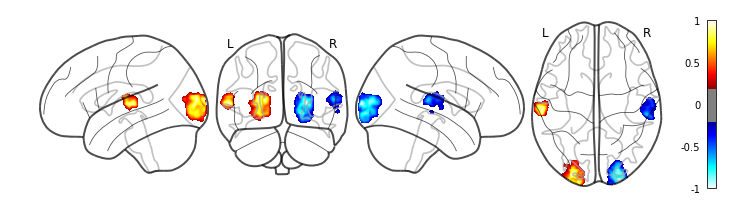

In [ ]:
plot_glass_brain('res.nii.gz', threshold=0.2, plot_abs=False, colorbar=True,
                 display_mode='lyrz', black_bg=False, cmap=cm.cold_hot)

## Visualize results on multiple slices

You can also visualize your results on multiple x, y or z sclises, with the MNI152 template as a background. In this approach you can change the following parameters:

- `display_mode`: use 'x', 'y', or 'z' do specify the plane to cut through
- `cut_coords`: specify which slices to cut, i.e. visualize
- `cmap`: what color scheme you want to use

In [ ]:
anatimg = 'templates/MNI152_T1_1mm.nii.gz'

### Cut through z-plane

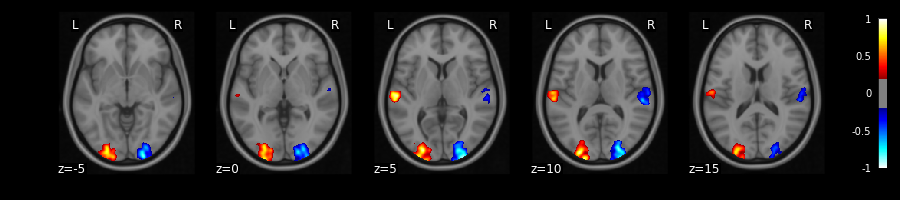

In [ ]:
plot_stat_map('res.nii.gz', bg_img=anatimg, threshold=0.2, 
              cut_coords=(-5, 0, 5, 10, 15), display_mode='z', cmap=cm.cold_hot)

### Cut through y-plane

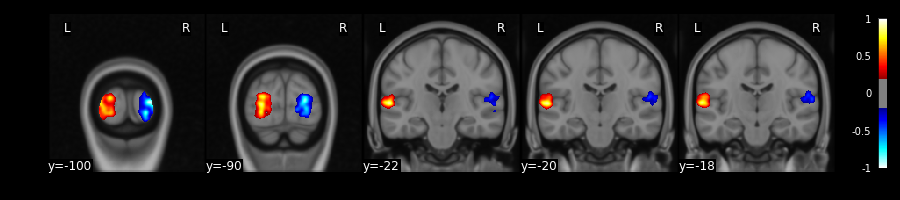

In [ ]:
plot_stat_map('res.nii.gz', bg_img=anatimg, threshold=0.2, 
              cut_coords=(-100, -90, -22, -20, -18), display_mode='y', cmap=cm.cold_hot)

### Cut through x-plane

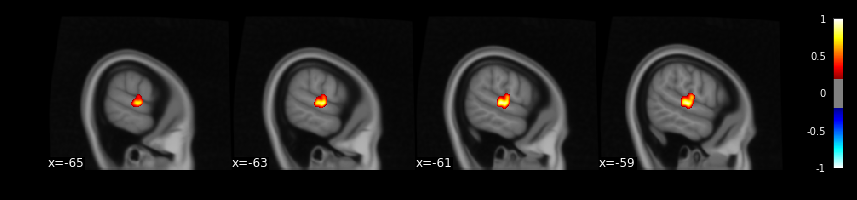

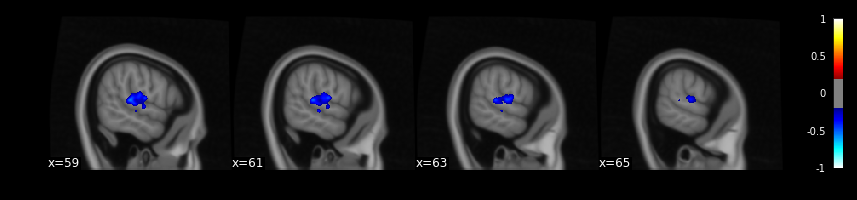

In [ ]:
plot_stat_map('res.nii.gz', bg_img=anatimg, threshold=0.2, 
              cut_coords=(-65, -63, -61, -59), display_mode='x', cmap=cm.cold_hot)
plot_stat_map('res.nii.gz', bg_img=anatimg, threshold=0.2, 
              cut_coords=(59, 61, 63, 65), display_mode='x', cmap=cm.cold_hot)

### Show all planes at a specific location

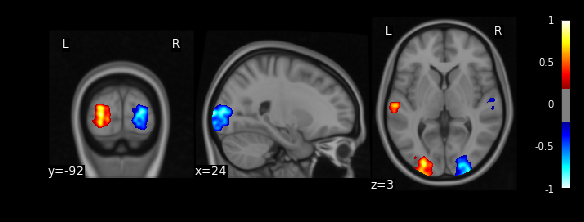

In [ ]:
plot_stat_map('res.nii.gz', bg_img=anatimg, threshold=0.2, display_mode='ortho',
              cut_coords=(24, -92, 3), draw_cross=False, cmap=cm.cold_hot)

# Extract Cluster Information

To extract information about the clusters, we can run the following command. This command will extract for each cluster, the size (in voxels), the intensity at its peak (arbitrary value around 1) and the anatomical location of the peak, according to two different atlases. More information about the atlases can be found [here](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases).

In [ ]:
from scipy.ndimage import label
labels, nlabels = label(img.get_data())

for i in range(nlabels):
    cSize = (labels == i + 1).sum()
    maxcoord = np.abs(data) == np.abs(data[labels == i + 1]).max()
    cPeak = np.round(data[maxcoord][0], 3)
    print('Cluster %.2d\n==========' % (i + 1))
    print('  Size = %s voxels\n  Peak Value: %s\n' % (cSize, cPeak))
    coord = np.dot(img.affine, np.hstack(
        (np.ravel(np.where(maxcoord)), 1)))[:3].tolist()
    coordStr = ','.join([str(coord[0]), str(coord[1]), str(coord[2])])
    %run atlas_reader.py all $coordStr 0 1

Cluster 01
  Size = 6339 voxels
  Peak Value: -0.67

Peak Information at [56.0, -27.0, 10.0]:
HarvardOxford                   42% b'Planum_Temporale'
HarvardOxford                    3% b"Heschl's_Gyrus_(includes_H1_and_H2)"
HarvardOxford                    3% b'Parietal_Operculum_Cortex'
HarvardOxford                    3% b'Superior_Temporal_Gyrus_posterior_division'
Juelich                          2% b'GM_Inferior_parietal_lobule_PF_R'
Juelich                          1% b'GM_Inferior_parietal_lobule_PFcm_R'


Cluster 02
  Size = 12661 voxels
  Peak Value: -1.0

Peak Information at [26.0, -101.0, 7.0]:
HarvardOxford                   52% b'Occipital_Pole'
Juelich                         68% b'GM_Visual_cortex_V2_BA18_R'
Juelich                         48% b'GM_Visual_cortex_V1_BA17_R'
Juelich                         13% b'WM_Optic_radiation_R'


Cluster 03
  Size = 13189 voxels
  Peak Value: 0.931

Peak Information at [-26.0, -95.0, 11.0]:
HarvardOxford                   60% b'Occi